<a href="https://colab.research.google.com/github/wny-unsw/TumorDifferentiationStageClassification/blob/main/TumorClassification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Classification V2

**Author:** Ningyuan WANG   
**Date:** April 2025  
**Description:**  
This notebook fine-tunes various [pretrained models](https://pytorch.org/vision/stable/models.html) (including VGG16, AlexNet, GoogLeNet, DenseNet161, ResNet50, and MobileNet) for a tumor differentiation stages classification task on [EBHI dataset](https://figshare.com/articles/dataset/EBH-HE-IDS/16999363/1). The models are modified by freezing the extraction layers and replacing the classifiers to preserve the learned representation while adapting to new task.  

The notebook includes the **training loop** and **model performance comparison**.  

The finetuned weights and performance graphs is [available here](https://drive.google.com/drive/folders/1wwa705CJ7JJQWga8efDHNo3pa-Nii9Om?usp=drive_link)


In [1]:
!nvidia-smi

Mon Apr 14 09:41:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!pip install torch-summary==1.4.4

In [4]:
import torch
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [5]:
# Move dataset to VM disk to significantly speed up I/O
!unzip '/content/drive/MyDrive/ColHis-IDS_restructured_mag200.zip' -d "/content"

Archive:  /content/drive/MyDrive/ColHis-IDS_restructured_mag200.zip
   creating: /content/200/Adenocarcinoma/
  inflating: /content/200/Adenocarcinoma/20201113-2013084-1_2013084-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013084-1_2013084-1-200-002.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013084-1_2013084-1-200-003.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013084-1_2013084-1-200-004.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013084-1_2013084-1-200-005.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013109-1_2013109-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013111-1_2013111-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013118-1_2013118-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013124-1_2013124-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-2013128-1_2013128-1-200-001.jpg  
  inflating: /content/200/Adenocarcinoma/20201113-

## Baseline Models

### Training

In [ ]:
class TumorClassification:
  transform = None
  dataset = None

  train_dataset = None
  val_dataset = None
  test_dataset = None

  train_dataloader = None
  val_dataloader = None
  test_dataloader = None

  device = None
  model = None

  def __init__(self, data_path, transform):
    self.transform = transform
    print('Loading dataset...\n')
    self.dataset = datasets.ImageFolder(root=data_path, transform=transform)
    print('Dataset Loaded.\n')
    self.dataset_summary()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Initialized.')

  def dataset_summary(self):
    print(f"Total images: {len(self.dataset)}")
    print(f"Number of classes: {len(self.dataset.classes)}")
    print(f"Class names: {self.dataset.classes}")
    print(f"Class-to-index mapping: {self.dataset.class_to_idx}\n")

  def split_dataset(self, train_portion = 0.7, val_portion = 0.15, _seed=42):
    total_size = len(self.dataset)
    train_size = int(train_portion * total_size)
    val_size = int(val_portion * total_size)
    test_size = total_size - train_size - val_size

    self.train_dataset, self.val_dataset, self.test_dataset = random_split(
        self.dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(_seed)
    )

  def prepare_dataloaders(self):
    self.train_dataloader = DataLoader(self.train_dataset, batch_size=1024, shuffle=True, pin_memory=True, drop_last=True)
    self.val_dataloader = DataLoader(self.val_dataset, batch_size=128, shuffle=False, pin_memory=True, drop_last=True)
    self.test_dataloader = DataLoader(self.test_dataset, batch_size=64, shuffle=False, pin_memory=True, drop_last=True)

  def init_model(self, model):
    self.model = model
    self.model = self.model.to(self.device)

  def train_model(
      self,
      weights_save_path,
      matrics_save_path,
      epochs = 10,
      lr = 0.0001,
      criterion = None,
      optimizer = None,
      ):

    if criterion is None:
      criterion = nn.CrossEntropyLoss()
    if optimizer is None:
      optimizer = optim.Adam(self.model.classifier.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # keep track of weights of highest val acc
    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(epochs):
        # Training
        self.model.train()
        running_loss = 0.0
        correct = 0
        for images, labels in self.train_dataloader:
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        avg_loss = running_loss / len(self.train_dataloader)
        accuracy = correct / len(self.train_dataset)

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

        # Validation
        self.model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in self.val_dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()

        val_acc = correct / len(self.val_dataset)
        val_accuracies.append(val_acc)

        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model_wts = model.state_dict()

    self.train_losses = train_losses
    self.train_accuracies = train_accuracies
    self.val_accuracies = val_accuracies

    torch.save(best_model_wts, weights_save_path)
    print("Best model saved with validation accuracy:", best_val_acc)

    self.save_metrics(epochs,matrics_save_path)

  def save_metrics(self, epochs, matrics_save_path):
    # Save the metrics as a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': self.train_losses,
        'Train Accuracy': self.train_accuracies,
        'Validation Accuracy': self.val_accuracies
    })

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(matrics_save_path, index=False)

    print("Training metrics saved.")

In [ ]:
data_path = '/content/200'

#### VGG16

In [ ]:
from torchvision.models import VGG16_Weights

In [ ]:
# For VGG16_Weights.IMAGENET1K_V1:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
tc.split_dataset()

In [ ]:
tc.prepare_dataloaders()

In [ ]:
# Load pretrained model
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# Freeze feature extractor layers
for param in model.features.parameters():
  param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 5) # adjust final layer for ImageNet
tc.init_model(model)

In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/vgg16_EBHI_mag_200.pth',
    './drive/MyDrive/Models/vgg16_metrics_EBHI_mag_200.csv',
    epochs = 10,
    lr = 0.0001
    )

Epoch 1, Avg Loss: 0.9346, Train Accuracy: 0.6672
Validation Accuracy: 0.7200
Epoch 2, Avg Loss: 0.4461, Train Accuracy: 0.8421
Validation Accuracy: 0.7782
Epoch 3, Avg Loss: 0.2937, Train Accuracy: 0.8981
Validation Accuracy: 0.7818
Epoch 4, Avg Loss: 0.1909, Train Accuracy: 0.9269
Validation Accuracy: 0.7855
Epoch 5, Avg Loss: 0.1302, Train Accuracy: 0.9495
Validation Accuracy: 0.8000
Epoch 6, Avg Loss: 0.0773, Train Accuracy: 0.9712
Validation Accuracy: 0.7927
Epoch 7, Avg Loss: 0.0510, Train Accuracy: 0.9806
Validation Accuracy: 0.7964
Epoch 8, Avg Loss: 0.0315, Train Accuracy: 0.9868
Validation Accuracy: 0.7927
Epoch 9, Avg Loss: 0.0168, Train Accuracy: 0.9930
Validation Accuracy: 0.7927
Epoch 10, Avg Loss: 0.0088, Train Accuracy: 0.9953
Validation Accuracy: 0.7927
Best model saved with validation accuracy: 0.8
Training metrics saved.


#### AlexNet

In [ ]:
from torchvision.models import AlexNet_Weights

In [ ]:
# For AlexNet_Weights.IMAGENET1K_V1:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.alexnet.html#torchvision.models.AlexNet_Weights
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)
tc.split_dataset()
tc.prepare_dataloaders()

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
# Load pretrained model
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
# Freeze feature extractor layers
for param in model.features.parameters():
  param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 5) # adjust final layer for ImageNet
tc.init_model(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 134MB/s]


In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/alexnet_EBHI_mag_200.pth',
    './drive/MyDrive/Models/alexnet_metrics_EBHI_mag_200.csv',
    epochs = 10,
    lr = 0.0001
    )

Epoch 1, Avg Loss: 1.0366, Train Accuracy: 0.6252
Validation Accuracy: 0.6982
Epoch 2, Avg Loss: 0.5927, Train Accuracy: 0.7994
Validation Accuracy: 0.7345
Epoch 3, Avg Loss: 0.4491, Train Accuracy: 0.8328
Validation Accuracy: 0.7782
Epoch 4, Avg Loss: 0.3833, Train Accuracy: 0.8616
Validation Accuracy: 0.7891
Epoch 5, Avg Loss: 0.3369, Train Accuracy: 0.8795
Validation Accuracy: 0.7855
Epoch 6, Avg Loss: 0.2837, Train Accuracy: 0.8989
Validation Accuracy: 0.7818
Epoch 7, Avg Loss: 0.2169, Train Accuracy: 0.9230
Validation Accuracy: 0.7927
Epoch 8, Avg Loss: 0.2031, Train Accuracy: 0.9238
Validation Accuracy: 0.8145
Epoch 9, Avg Loss: 0.1497, Train Accuracy: 0.9502
Validation Accuracy: 0.8109
Epoch 10, Avg Loss: 0.1257, Train Accuracy: 0.9533
Validation Accuracy: 0.8109
Best model saved with validation accuracy: 0.8145454545454546
Training metrics saved.


#### GoogLeNet

In [ ]:
from torchvision.models import GoogLeNet_Weights

In [ ]:
# For GoogLeNet_Weights.IMAGENET1K_V1:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.googlenet.html#torchvision.models.GoogLeNet_Weights
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)
tc.split_dataset()
tc.prepare_dataloaders()

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
# Load pretrained model
model = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.fc = nn.Linear(1024, 5) # adjust final layer for ImageNet
tc.init_model(model)

In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/googlenet_EBHI_mag_200.pth',
    './drive/MyDrive/Models/googlenet_metrics_EBHI_mag_200.csv',
    epochs = 20,
    lr = 0.001,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    )

Epoch 1, Avg Loss: 1.3618, Train Accuracy: 0.3834
Validation Accuracy: 0.3782
Epoch 2, Avg Loss: 1.0570, Train Accuracy: 0.6431
Validation Accuracy: 0.7091
Epoch 3, Avg Loss: 0.8744, Train Accuracy: 0.7628
Validation Accuracy: 0.6764
Epoch 4, Avg Loss: 0.7736, Train Accuracy: 0.7597
Validation Accuracy: 0.7309
Epoch 5, Avg Loss: 0.7008, Train Accuracy: 0.8033
Validation Accuracy: 0.7309
Epoch 6, Avg Loss: 0.6329, Train Accuracy: 0.8002
Validation Accuracy: 0.7491
Epoch 7, Avg Loss: 0.5962, Train Accuracy: 0.8196
Validation Accuracy: 0.7382
Epoch 8, Avg Loss: 0.5551, Train Accuracy: 0.8289
Validation Accuracy: 0.7564
Epoch 9, Avg Loss: 0.5368, Train Accuracy: 0.8227
Validation Accuracy: 0.7564
Epoch 10, Avg Loss: 0.5135, Train Accuracy: 0.8250
Validation Accuracy: 0.7673
Epoch 11, Avg Loss: 0.4898, Train Accuracy: 0.8421
Validation Accuracy: 0.7673
Epoch 12, Avg Loss: 0.4773, Train Accuracy: 0.8398
Validation Accuracy: 0.7745
Epoch 13, Avg Loss: 0.4534, Train Accuracy: 0.8484
Validation

#### DenseNet161

In [ ]:
from torchvision.models import DenseNet161_Weights

In [ ]:
# For DenseNet161_Weights.IMAGENET1K_V1:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.densenet161.html#torchvision.models.DenseNet161_Weights
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)
tc.split_dataset()
tc.prepare_dataloaders()

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
# Load pretrained model
model = models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(2208, 5) # adjust final layer for ImageNet
tc.init_model(model)

In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (14,112)
|    └─BatchNorm2d: 2-2                  (192)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (101,952)
|    |    └─_DenseLayer: 3-2             (111,264)
|    |    └─_DenseLayer: 3-3             (120,576)
|    |    └─_DenseLayer: 3-4             (129,888)
|    |    └─_DenseLayer: 3-5             (139,200)
|    |    └─_DenseLayer: 3-6             (148,512)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (768)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (73,728)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (120,576)
|    |    └─_DenseLayer: 3-12            (129,88

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (14,112)
|    └─BatchNorm2d: 2-2                  (192)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (101,952)
|    |    └─_DenseLayer: 3-2             (111,264)
|    |    └─_DenseLayer: 3-3             (120,576)
|    |    └─_DenseLayer: 3-4             (129,888)
|    |    └─_DenseLayer: 3-5             (139,200)
|    |    └─_DenseLayer: 3-6             (148,512)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (768)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (73,728)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (120,576)
|    |    └─_DenseLayer: 3-12            (129,88

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/densenet161_EBHI_mag_200.pth',
    './drive/MyDrive/Models/densenet161_metrics_EBHI_mag_200.csv',
    epochs = 20,
    lr = 0.001
    )

Epoch 1, Avg Loss: 1.1521, Train Accuracy: 0.5918
Validation Accuracy: 0.7382
Epoch 2, Avg Loss: 0.7690, Train Accuracy: 0.7994
Validation Accuracy: 0.7455
Epoch 3, Avg Loss: 0.5970, Train Accuracy: 0.8165
Validation Accuracy: 0.7564
Epoch 4, Avg Loss: 0.5221, Train Accuracy: 0.8336
Validation Accuracy: 0.7782
Epoch 5, Avg Loss: 0.4537, Train Accuracy: 0.8507
Validation Accuracy: 0.7673
Epoch 6, Avg Loss: 0.4139, Train Accuracy: 0.8631
Validation Accuracy: 0.7782
Epoch 7, Avg Loss: 0.3889, Train Accuracy: 0.8748
Validation Accuracy: 0.7673
Epoch 8, Avg Loss: 0.3555, Train Accuracy: 0.8802
Validation Accuracy: 0.7891
Epoch 9, Avg Loss: 0.3319, Train Accuracy: 0.8997
Validation Accuracy: 0.7745
Epoch 10, Avg Loss: 0.3236, Train Accuracy: 0.8950
Validation Accuracy: 0.7927
Epoch 11, Avg Loss: 0.3118, Train Accuracy: 0.9129
Validation Accuracy: 0.7818
Epoch 12, Avg Loss: 0.2912, Train Accuracy: 0.9145
Validation Accuracy: 0.7927
Epoch 13, Avg Loss: 0.2810, Train Accuracy: 0.9114
Validation

#### ResNet50

In [ ]:
from torchvision.models import ResNet50_Weights

In [ ]:
# For ResNet50_Weights.IMAGENET1K_V2:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)
tc.split_dataset()
tc.prepare_dataloaders()

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
# Load pretrained model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 5) # adjust final layer for ImageNet
tc.init_model(model)

In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/resnet50_EBHI_mag_200.pth',
    './drive/MyDrive/Models/resnet50_metrics_EBHI_mag_200.csv',
    epochs = 20,
    lr = 0.001,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    )

Epoch 1, Avg Loss: 1.2038, Train Accuracy: 0.5692
Validation Accuracy: 0.5782
Epoch 2, Avg Loss: 0.9133, Train Accuracy: 0.7302
Validation Accuracy: 0.7018
Epoch 3, Avg Loss: 0.7525, Train Accuracy: 0.8017
Validation Accuracy: 0.7236
Epoch 4, Avg Loss: 0.6485, Train Accuracy: 0.8266
Validation Accuracy: 0.7273
Epoch 5, Avg Loss: 0.5890, Train Accuracy: 0.8375
Validation Accuracy: 0.7345
Epoch 6, Avg Loss: 0.5293, Train Accuracy: 0.8414
Validation Accuracy: 0.7527
Epoch 7, Avg Loss: 0.4852, Train Accuracy: 0.8523
Validation Accuracy: 0.7600
Epoch 8, Avg Loss: 0.4446, Train Accuracy: 0.8631
Validation Accuracy: 0.7745
Epoch 9, Avg Loss: 0.4199, Train Accuracy: 0.8709
Validation Accuracy: 0.7818
Epoch 10, Avg Loss: 0.3951, Train Accuracy: 0.8826
Validation Accuracy: 0.7855
Epoch 11, Avg Loss: 0.3741, Train Accuracy: 0.8935
Validation Accuracy: 0.7818
Epoch 12, Avg Loss: 0.3597, Train Accuracy: 0.8927
Validation Accuracy: 0.7818
Epoch 13, Avg Loss: 0.3401, Train Accuracy: 0.9059
Validation

#### MobileNet

In [ ]:
from torchvision.models import MobileNet_V3_Large_Weights

In [ ]:
# For MobileNet_V3_Large_Weights.IMAGENET1K_V2:
# https://pytorch.org/vision/stable/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.MobileNet_V3_Large_Weights
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
tc = TumorClassification(data_path,transform)
tc.split_dataset()
tc.prepare_dataloaders()

Loading dataset...

Dataset Loaded.

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [ ]:
# Load pretrained model
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 5) # adjust final layer for ImageNet
tc.init_model(model)

In [ ]:
summary(tc.model, input_size=(3, 224, 224),device=tc.device.type)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (432)
|    |    └─BatchNorm2d: 3-2                       (32)
|    |    └─Hardswish: 3-3                         --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (464)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (3,440)
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        (4,440)
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        (10,328)
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        (20,992)
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                    

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            (432)
|    |    └─BatchNorm2d: 3-2                       (32)
|    |    └─Hardswish: 3-3                         --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        (464)
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        (3,440)
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        (4,440)
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        (10,328)
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        (20,992)
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                    

In [ ]:
tc.train_model(
    './drive/MyDrive/Models/mobilenet_EBHI_mag_200.pth',
    './drive/MyDrive/Models/mobilenet_metrics_EBHI_mag_200.csv',
    epochs = 20,
    lr = 0.008
    )

Epoch 1, Avg Loss: 1.6030, Train Accuracy: 0.1804
Validation Accuracy: 0.6400
Epoch 2, Avg Loss: 2.5843, Train Accuracy: 0.5630
Validation Accuracy: 0.2109
Epoch 3, Avg Loss: 3.2866, Train Accuracy: 0.3344
Validation Accuracy: 0.2291
Epoch 4, Avg Loss: 3.1716, Train Accuracy: 0.4370
Validation Accuracy: 0.4400
Epoch 5, Avg Loss: 3.0317, Train Accuracy: 0.4215
Validation Accuracy: 0.4109
Epoch 6, Avg Loss: 1.2351, Train Accuracy: 0.5140
Validation Accuracy: 0.3636
Epoch 7, Avg Loss: 0.7407, Train Accuracy: 0.6120
Validation Accuracy: 0.2945
Epoch 8, Avg Loss: 1.4999, Train Accuracy: 0.4914
Validation Accuracy: 0.2873
Epoch 9, Avg Loss: 0.8512, Train Accuracy: 0.6143
Validation Accuracy: 0.3018
Epoch 10, Avg Loss: 0.4965, Train Accuracy: 0.6672
Validation Accuracy: 0.3600
Epoch 11, Avg Loss: 0.5960, Train Accuracy: 0.6260
Validation Accuracy: 0.3782
Epoch 12, Avg Loss: 0.6955, Train Accuracy: 0.6198
Validation Accuracy: 0.3527
Epoch 13, Avg Loss: 0.6019, Train Accuracy: 0.6213
Validation

### Model Performance Comparison

In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
def read_csv_from_directory(directory_path):
  csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
  dataframes = {}

  for _file in csv_files:
      file_path = os.path.join(directory_path, _file)
      df = pd.read_csv(file_path)
      model_name = _file.split('_')[0]  # Use the filename as the model name
      dataframes[model_name] = df

  return dataframes

In [ ]:
metrics = read_csv_from_directory('./drive/MyDrive/Models/')

In [ ]:
def plot_training_loss(dataframes,save_path = None):
  plt.figure(figsize=(10, 6))

  for model_name, df in dataframes.items():
      epochs = df['Epoch']
      train_loss = df['Train Loss']
      plt.plot(epochs, train_loss, label=model_name)

  plt.xlabel('Epochs')
  plt.ylabel('Training Loss')
  plt.title('Training Loss Over Epochs')
  plt.legend()
  plt.grid(True)
  if save_path is not None:
    plt.savefig(save_path)
  plt.show()

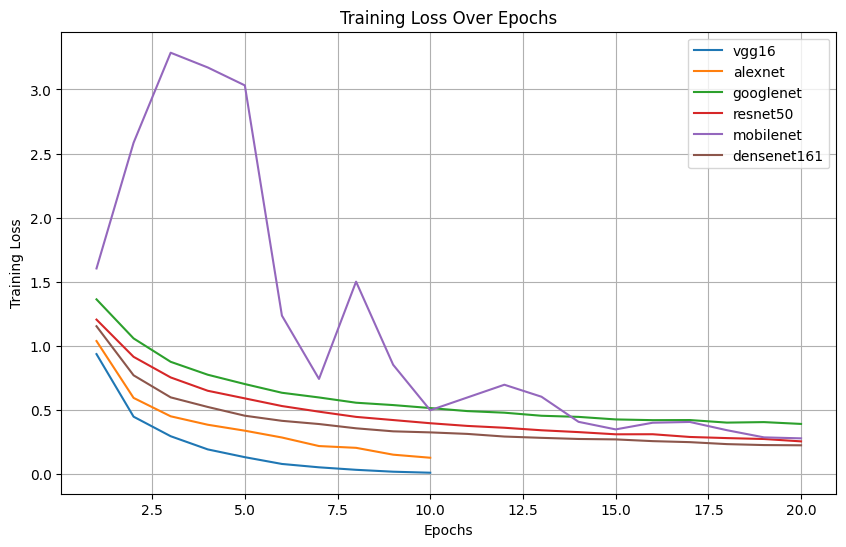

In [ ]:
plot_training_loss(metrics,'./drive/MyDrive/Models/Metrics/Training-Loss-Over-Epochs.png')

In [ ]:
def plot_accuracy(dataframes,save_path = None):
  plt.figure(figsize=(12, 6))

  for model_name, df in dataframes.items():
      epochs = df['Epoch']
      train_accuracy = df['Train Accuracy']
      val_accuracy = df['Validation Accuracy']

      plt.plot(epochs, val_accuracy, label=f'{model_name} Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy Over Epochs')
  plt.legend()
  plt.grid(True)
  if save_path is not None:
    plt.savefig(save_path)
  plt.show()


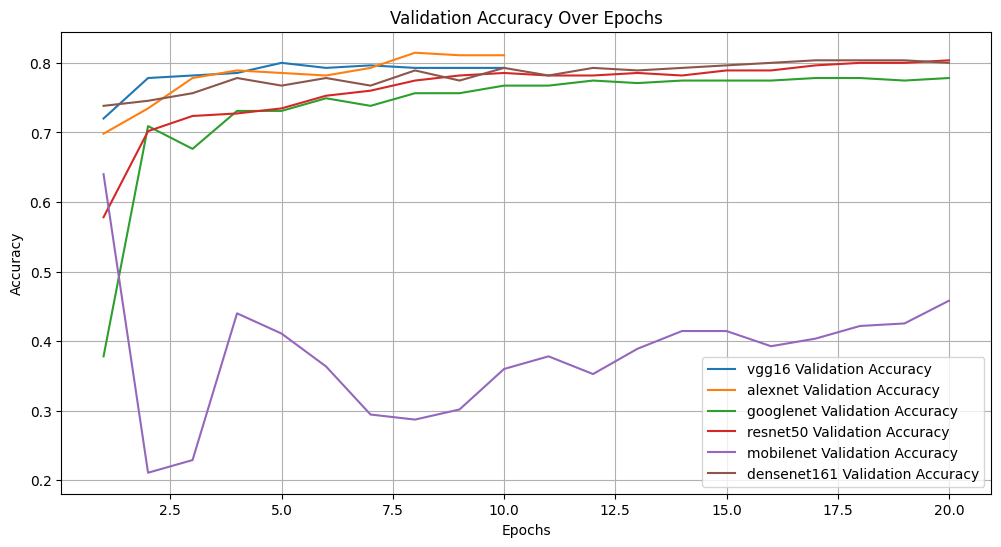

In [ ]:
plot_accuracy(metrics,'./drive/MyDrive/Models/Metrics/Validation-Accuracy-Over-Epochs.png')

In [ ]:
def plot_best_validation_accuracy(dataframes,save_path = None):
  best_accuracies = []  # Store the best accuracy for each model
  model_names = []  # Store the model names

  # Find the best validation accuracy for each model
  for model_name, df in dataframes.items():
      best_val_acc = df['Validation Accuracy'].max()  # Find max validation accuracy
      best_accuracies.append(best_val_acc)
      model_names.append(model_name)

  # Plot the best validation accuracy for each model
  plt.figure(figsize=(10, 6))
  plt.bar(model_names, best_accuracies, color='skyblue')
  plt.xlabel('Model')
  plt.ylabel('Best Validation Accuracy')
  plt.title('Best Validation Accuracy for Each Model')
  plt.xticks(rotation=45, ha="right")  # Rotate model names for better readability
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()  # Adjust layout to prevent overlapping labels

  # Add legends (in this case, just the bar labels as the models)
  plt.legend(["Best Validation Accuracy"], loc="upper left")
  if save_path is not None:
    plt.savefig(save_path)
  plt.show()

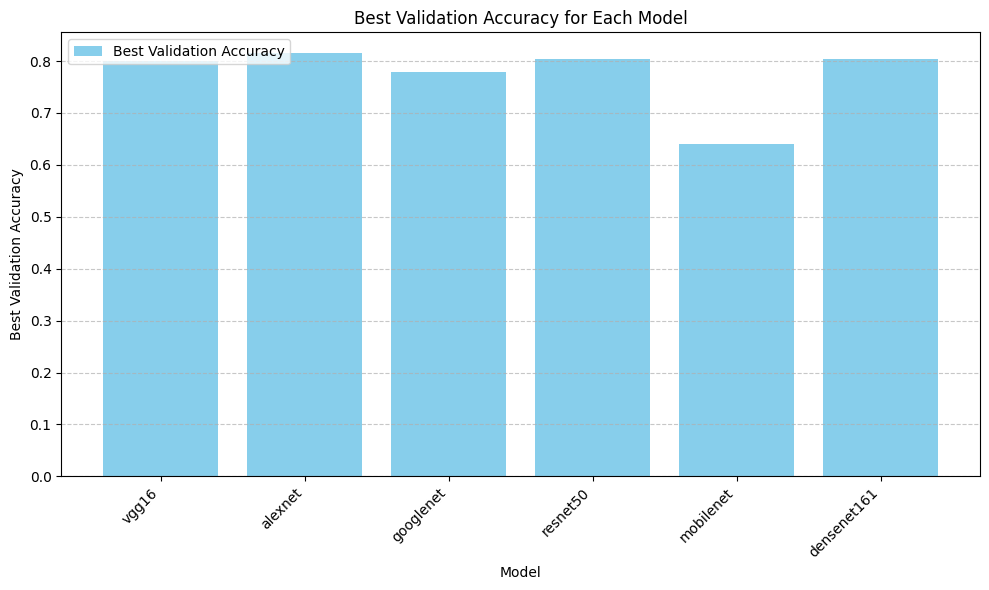

In [ ]:
plot_best_validation_accuracy(metrics,'./drive/MyDrive/Models/Metrics/Best-Validation-Accuracy.png')

## Improvement

By experimenting on pretrained data, we have four models achieves 0.8+ accuracy. And we find that resnet50 has the highest acc@1 and acc@5 and smallest model size on ImageNet-1K among them. We believe in the potential of this model and will modify our system with it.  

What we did: apply data augmentation, introduce class weights, utilize lr schedualing.

In [6]:
from torch.utils.data import Dataset
from collections import Counter
from torchvision.models import ResNet50_Weights

In [7]:
data_path = '/content/200'

In [8]:
class CustomDataset(Dataset):
  def __init__(self, subset, transform):
    self.subset = subset
    self.transform = transform

  def __getitem__(self, index):
    x, y = self.subset[index]
    x = self.transform(x)
    return x, y

  def __len__(self):
    return len(self.subset)

In [30]:
class TumorClassificationImproved:
  full_dataset = None
  train_transform = None # w/ data augmentation
  val_test_transform = None # w/o augmentation

  train_dataset = None
  val_dataset = None
  test_dataset = None

  train_dataloader = None
  val_dataloader = None
  test_dataloader = None

  device = None
  model = None

  def __init__(self, data_path, train_transform, val_test_transform):
    print('Loading dataset...\n')
    self.full_dataset = datasets.ImageFolder(root=data_path)
    self.dataset_summary()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.train_transform = train_transform
    self.val_test_transform = val_test_transform
    print('Initialized.')

  def dataset_summary(self):
    print(f"Total images: {len(self.full_dataset)}")
    print(f"Number of classes: {len(self.full_dataset.classes)}")
    print(f"Class names: {self.full_dataset.classes}")
    print(f"Class-to-index mapping: {self.full_dataset.class_to_idx}\n")

  def split_dataset(self, train_portion = 0.7, val_portion = 0.15, _seed=42):
    total_size = len(self.full_dataset)
    train_size = int(train_portion * total_size)
    val_size = int(val_portion * total_size)
    test_size = total_size - train_size - val_size

    raw_train_dataset, raw_val_dataset, raw_test_dataset = random_split(
        self.full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(_seed)
    )

    self.train_dataset = CustomDataset(raw_train_dataset, self.train_transform)
    self.val_dataset = CustomDataset(raw_val_dataset, self.val_test_transform)
    self.test_dataset = CustomDataset(raw_test_dataset, self.val_test_transform)

  def prepare_dataloaders(self):
    self.train_dataloader = DataLoader(self.train_dataset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)
    self.val_dataloader = DataLoader(self.val_dataset, batch_size=128, shuffle=False, pin_memory=True, drop_last=True)
    self.test_dataloader = DataLoader(self.test_dataset, batch_size=64, shuffle=False, pin_memory=True, drop_last=True)

  def get_class_weights(self):
    labels = [self.train_dataset[i][1] for i in range(len(self.train_dataset))]
    class_counts = Counter(labels)
    total = sum(class_counts.values())
    weights = [total / class_counts[i] for i in range(len(class_counts))]
    return torch.FloatTensor(weights).to(self.device)

  def init_model(self, model):
    self.model = model.to(self.device)

  def train_model(
      self,
      weights_save_path,
      matrics_save_path,
      epochs = 10,
      lr = 0.0001,
      criterion = None,
      optimizer = None,
      scheduler = None,
      ):

    if criterion is None:
      weights = self.get_class_weights()
      criterion = nn.CrossEntropyLoss(weight=weights)
    if optimizer is None:
      optimizer = optim.Adam(self.model.classifier.parameters(), lr=lr)
    if scheduler is None:
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer,
          mode='max',
          factor=0.5,
          patience=2,
          verbose=True)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # keep track of weights of highest val acc
    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(epochs):
      # Training
      self.model.train()
      running_loss = 0.0
      correct = 0
      for images, labels in self.train_dataloader:
        images, labels = images.to(self.device), labels.to(self.device)

        optimizer.zero_grad()
        outputs = self.model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

      avg_loss = running_loss / len(self.train_dataloader)
      accuracy = correct / len(self.train_dataset)

      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

      # Validation
      self.model.eval()
      correct = 0
      with torch.no_grad():
          for images, labels in self.val_dataloader:
              images, labels = images.to(self.device), labels.to(self.device)
              outputs = self.model(images)
              _, preds = torch.max(outputs, 1)
              correct += (preds == labels).sum().item()

      val_acc = correct / len(self.val_dataset)
      val_accuracies.append(val_acc)

      print(f"Validation Accuracy: {val_acc:.4f}")

      if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()

    self.train_losses = train_losses
    self.train_accuracies = train_accuracies
    self.val_accuracies = val_accuracies

    torch.save(best_model_wts, weights_save_path)
    print("Best model saved with validation accuracy:", best_val_acc)

    self.save_metrics(epochs,matrics_save_path)

  def save_metrics(self, epochs, matrics_save_path):
    # Save the metrics as a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': self.train_losses,
        'Train Accuracy': self.train_accuracies,
        'Validation Accuracy': self.val_accuracies
    })

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(matrics_save_path, index=False)

    print("Training metrics saved.")

In [31]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

In [32]:
val_test_transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

In [33]:
tci = TumorClassificationImproved(data_path, train_transform, val_test_transform)
tci.split_dataset()
tci.prepare_dataloaders()

Loading dataset...

Total images: 1838
Number of classes: 5
Class names: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Class-to-index mapping: {'Adenocarcinoma': 0, 'High-grade IN': 1, 'Low-grade IN': 2, 'Normal': 3, 'Polyp': 4}

Initialized.


In [34]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [35]:
class CustomClassifier(nn.Module):
  def __init__(self, input_features=2048, num_classes=5):
    super(CustomClassifier, self).__init__()
    self.classifier = nn.Sequential(
      nn.Linear(input_features, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    return self.classifier(x)

In [36]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.fc = CustomClassifier(2048, 5)
tci.init_model(model)

In [26]:
summary(tci.model, input_size=(3, 224, 224),device=tci.device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [37]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

In [45]:
tci.train_model(
  './drive/MyDrive/Models/improved_EBHI_mag_200.pth',
  './drive/MyDrive/Models/improved_metrics_EBHI_mag_200.csv',
  epochs = 50,
  lr = 0.001,
  criterion = nn.CrossEntropyLoss(weight=tci.get_class_weights()),
  optimizer = optimizer,
  scheduler = scheduler
  )

Epoch 1, Avg Loss: 0.2962, Train Accuracy: 0.8756
Validation Accuracy: 0.8400
Epoch 2, Avg Loss: 0.2561, Train Accuracy: 0.8904
Validation Accuracy: 0.8545
Epoch 3, Avg Loss: 0.2954, Train Accuracy: 0.8802
Validation Accuracy: 0.8327
Epoch 4, Avg Loss: 0.2898, Train Accuracy: 0.8904
Validation Accuracy: 0.8400
Epoch 5, Avg Loss: 0.3076, Train Accuracy: 0.8779
Validation Accuracy: 0.8291
Epoch 6, Avg Loss: 0.2730, Train Accuracy: 0.8872
Validation Accuracy: 0.8400
Epoch 7, Avg Loss: 0.3077, Train Accuracy: 0.8865
Validation Accuracy: 0.8436
Epoch 8, Avg Loss: 0.2935, Train Accuracy: 0.8694
Validation Accuracy: 0.8364
Epoch 9, Avg Loss: 0.3039, Train Accuracy: 0.8764
Validation Accuracy: 0.8364
Epoch 10, Avg Loss: 0.3457, Train Accuracy: 0.8569
Validation Accuracy: 0.8364
Epoch 11, Avg Loss: 0.3043, Train Accuracy: 0.8748
Validation Accuracy: 0.8364
Epoch 12, Avg Loss: 0.2890, Train Accuracy: 0.8795
Validation Accuracy: 0.8400
Epoch 13, Avg Loss: 0.3240, Train Accuracy: 0.8733
Validation